# Harmonic Oscillator

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from module.hamilton_class import HamiltonSystem
from module.plot_class import Plotter
from module.nambu_class import NambuSystem
from module.sampling import metropolis_hastings, sample_initial_conditions


# General parameters for different kinds of dynamics
k = 1.0 # spring constant
m = 1.0 # mass
t_max = 30.0 # maximum time

potential = lambda x: k * (x**2) / 2

### Derivatives

In [2]:
# Hamiltonian dynamics
# H = p^2 / 2m + kx^2 / 2
# x dot = dH / dp
# p dot = - dH / dx

def Hamilton_x_dot(x, p):
    return p / m  # For a simple harmonic oscillator, dx/dt = p / m

def Hamilton_p_dot(x, p):
    return -k * x  # For a simple harmonic oscillator, dp/dt = - k x


# Nambu dynamics
# H = p^2 / 2m + kx^2 / 2 + r^2 / 2m
# G = r^2 / 2m + kx^2 / 4
# x dot = dH / dp * dG / dr - dH / dr * dG / dp
# p dot = dH / dr * dG / dx - dH / dx * dG / dr
# r dot = dH / dx * dG / dp - dH / dp * dG / dx

def Nambu_x_dot(x, p, r):
    return p * r  

def Nambu_p_dot(x, p, r):
    return -(k / 2) * r * x 

def Nambu_r_dot(x, p, r):
    return -(k / 2) * p * x 

### Single initial condition using Hamilton dynamics


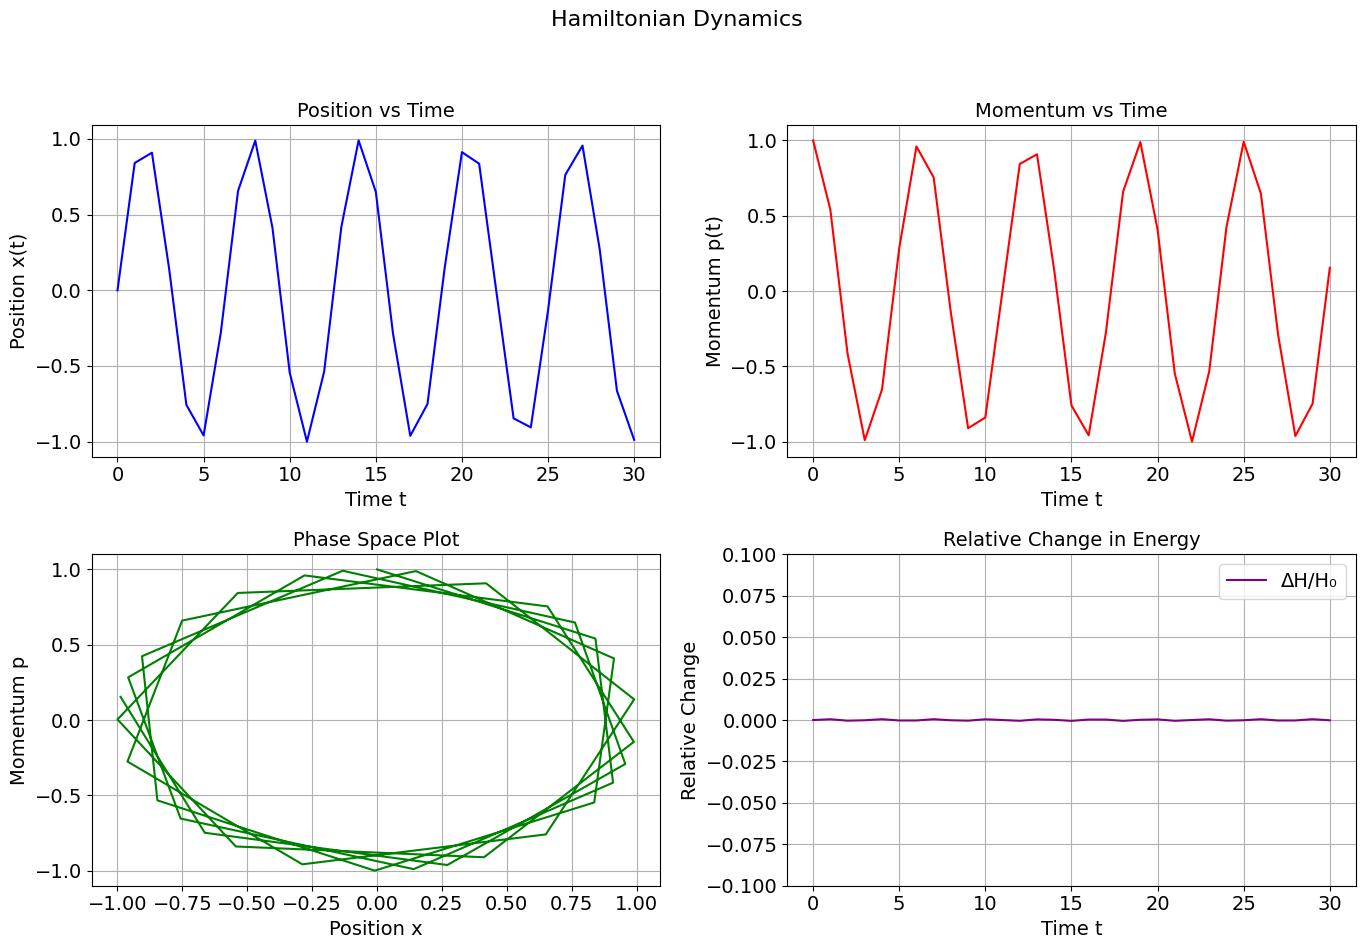

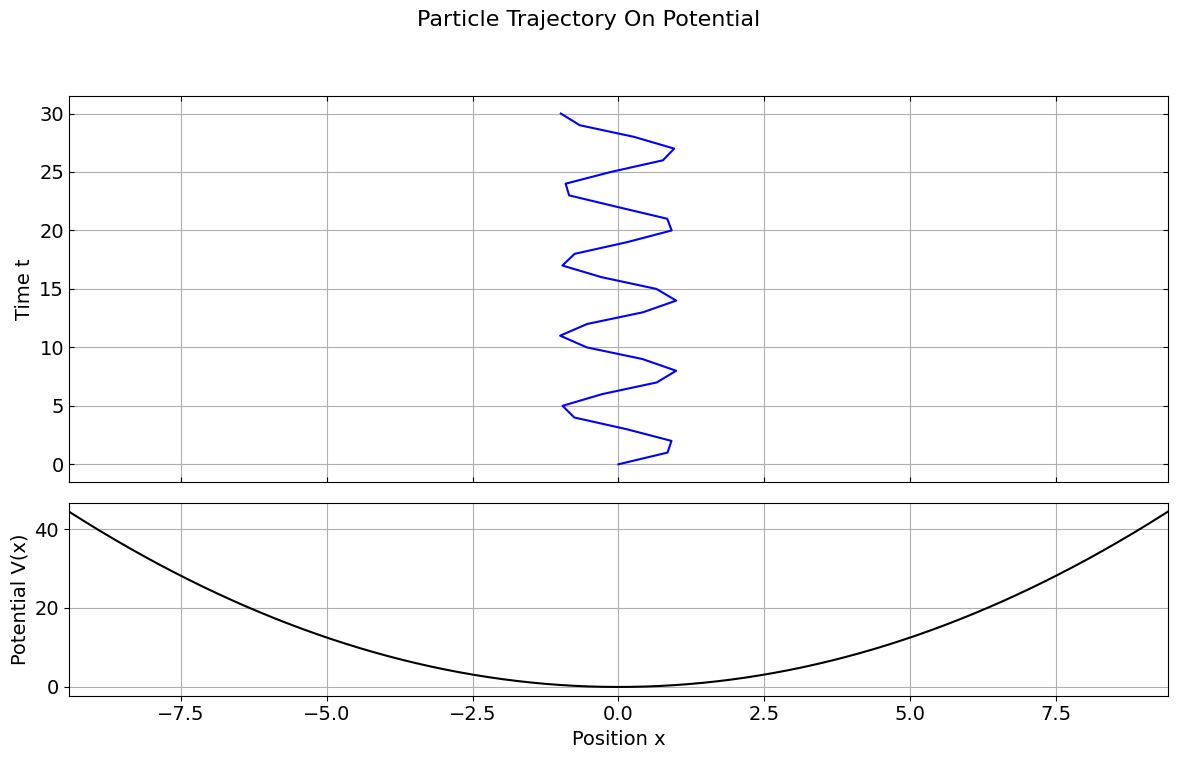

>>> Number of force calculation:  30000


In [3]:
# Define the parameters
delta_t = 0.001  # Time step
N_force = 0  # Number of force calculation

# Fixed initial condition
x0, p0 = 0.0, 1.0

# Create Hamiltonian system
hamilton_system = HamiltonSystem(Hamilton_p_dot, Hamilton_x_dot, t_max, delta_t)

# Simulate for the fixed initial condition
t_array, x_array, p_array = hamilton_system.simulate(x0, p0)
N_force += len(t_array) - 1 # each time of simulate includes a dV / dx calculation

# Pick the data at each second
t_sampled, x_sampled, p_sampled = hamilton_system.pick_data(t_array, x_array, p_array)

# Calculate energy
energy_sampled = 0.5 * (p_sampled**2) / m + k * (x_sampled**2) / 2

# Plotting
plotter = Plotter()
plotter.static_plots("Hamiltonian", t_sampled, x_sampled, p_sampled, energy_sampled)
plotter.trajectory_plot(x_sampled, t_sampled, potential)

print(">>> Number of force calculation: ", N_force)

### Single initial condition using Nambu dynamics

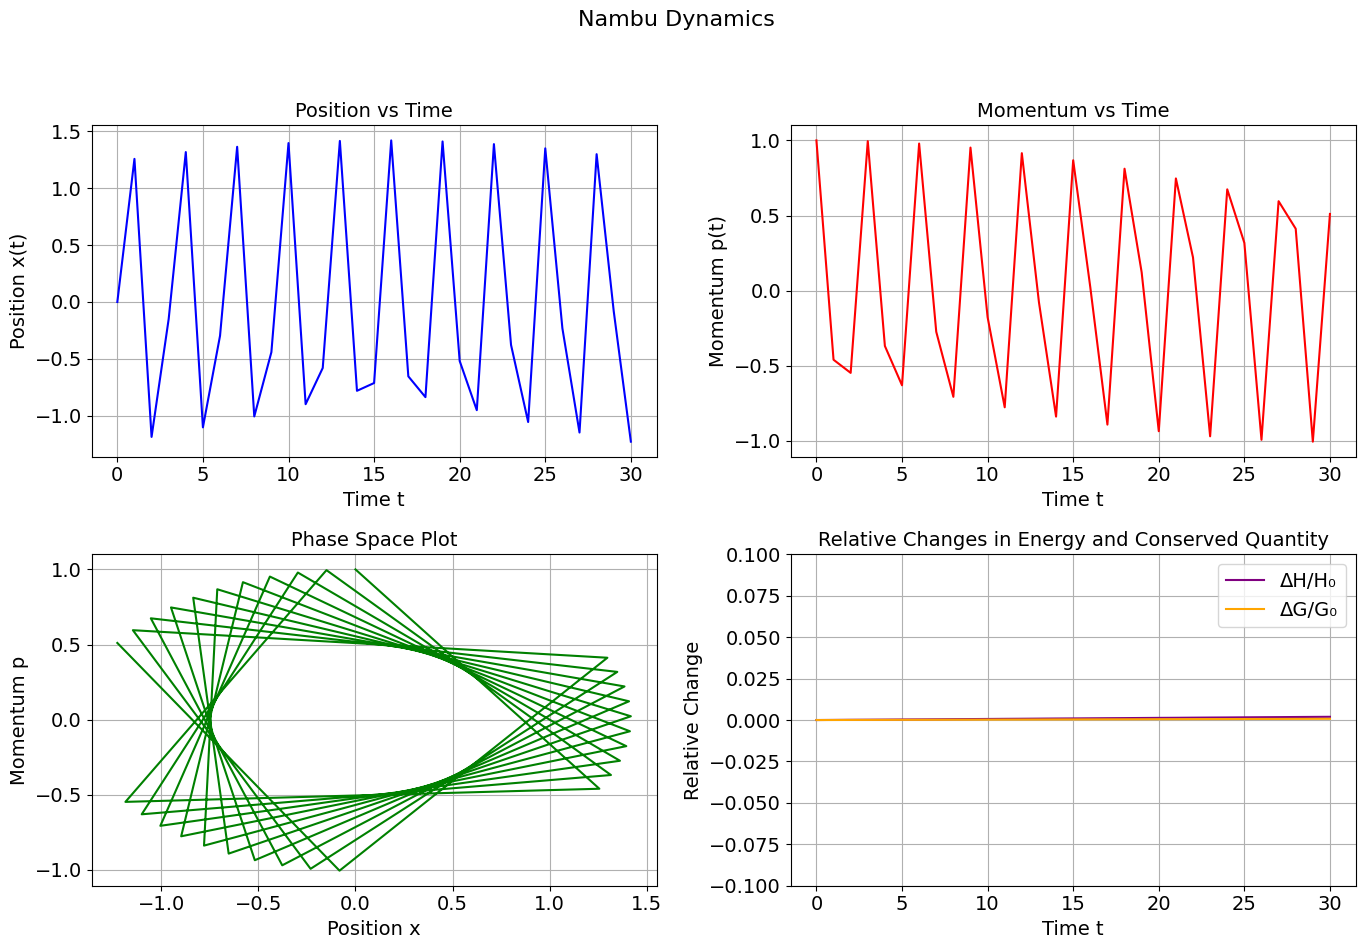

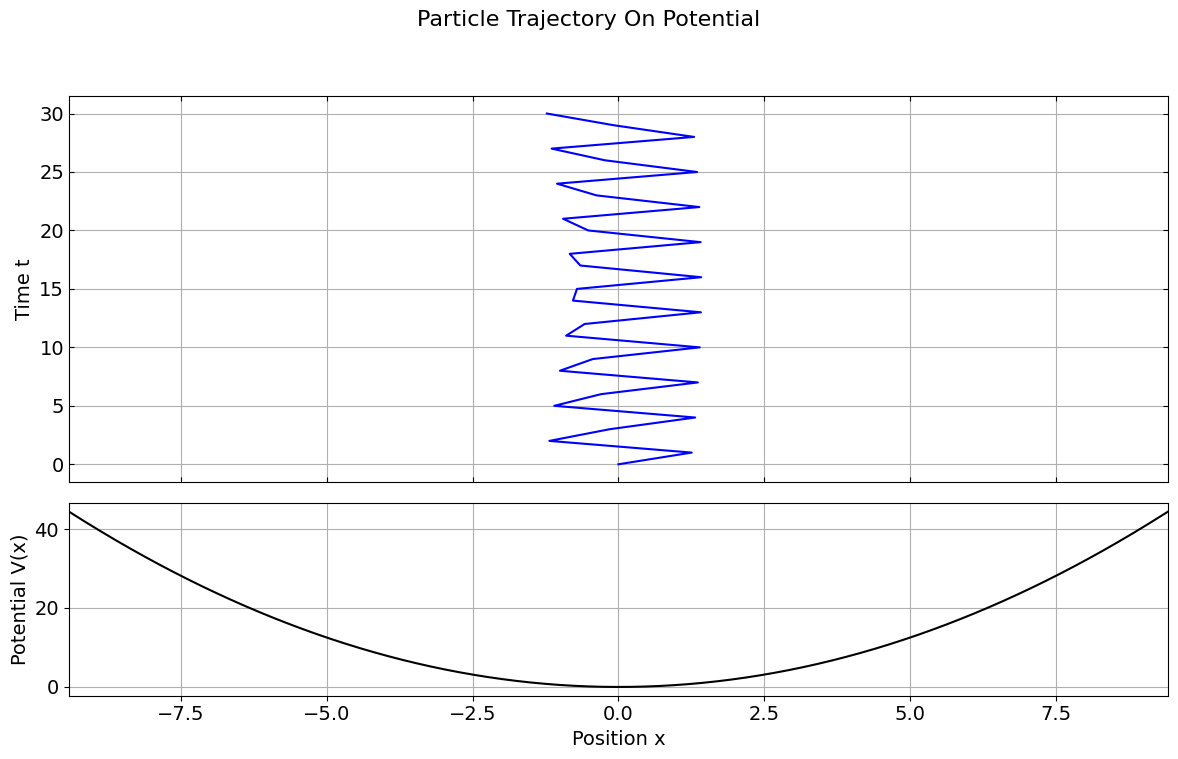

>>> Number of force calculation:  300000


In [4]:
# Define the parameters
delta_t = 0.0001  # Time step
N_force = 0


# Initial conditions
x0 = 0.0
p0 = 1.0
r0 = 3.0

nambu_system = NambuSystem(Nambu_x_dot, Nambu_p_dot, Nambu_r_dot, t_max, delta_t)

t_array, x_array, p_array, r_array = nambu_system.simulate(x0, p0, r0)
N_force += len(t_array) - 1 # each time of simulate includes a dV / dx calculation, since dG / dx = ( dH / dx ) / 2

t_sampled, x_sampled, p_sampled, r_sampled = nambu_system.pick_data(t_array, x_array, p_array, r_array)

energy_sampled = 0.5 * (p_sampled**2) / m + k * (x_sampled**2) / 2 + 0.5 * (r_sampled**2) / m 
conserved_G = 0.5 * (r_sampled**2) / m + k * (x_sampled**2) / 4

plotter = Plotter()
plotter.static_plots("Nambu", t_sampled, x_sampled, p_sampled, energy_sampled, conserved_G)
plotter.trajectory_plot(x_sampled, t_sampled, potential)

print(">>> Number of force calculation: ", N_force)

### Sampling different initial conditions


>>> Generated 2000 sets of p0 satisfies p(p0) ∝ exp(-p0^2 / 2m)


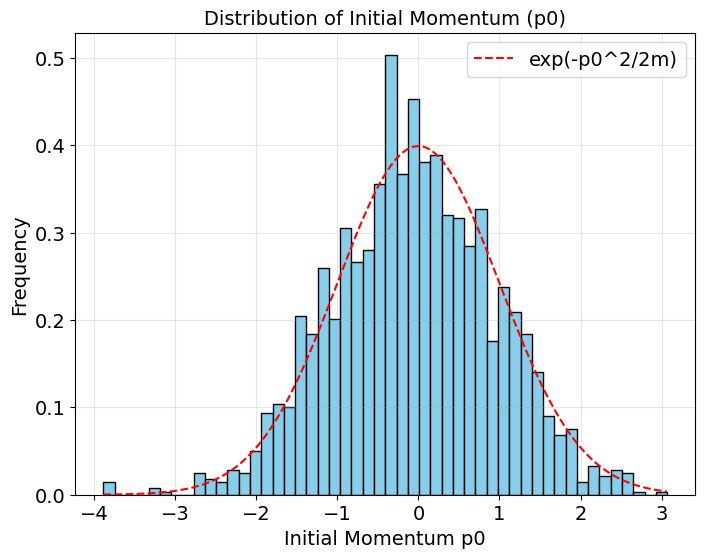

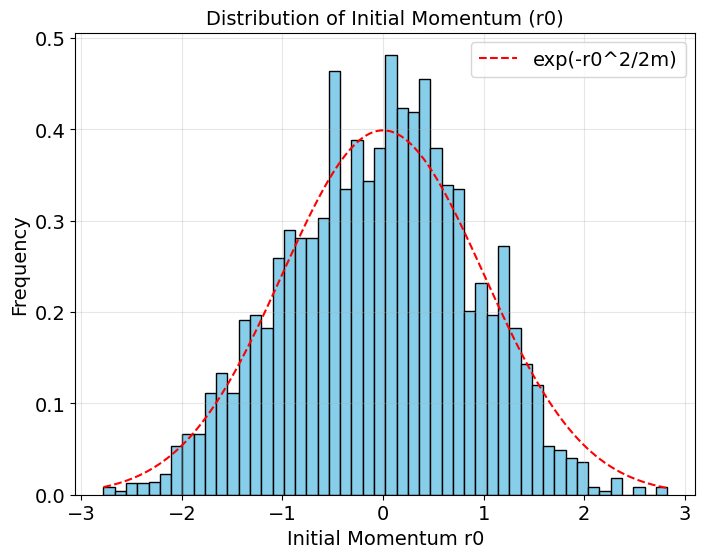

In [5]:
Nsamp = 2000
p_term = lambda p: p**2 / (2 * m)
r_term = lambda r: r**2 / (2 * m)

samples = sample_initial_conditions(Nsamp, p_term, r_term)
p0_samples, r0_samples = zip(*samples)
print(f"\n>>> Generated {Nsamp} sets of (p0, r0) satisfies p(p0, r0) ∝ exp(-H(p0, r0))")

# Create a histogram of p0_samples
plt.figure(figsize=(8, 6))
plt.hist(p0_samples, bins=50, color='skyblue', edgecolor='black', density=True)
# Add theoretical distribution line
x_range = np.linspace(min(p0_samples), max(p0_samples), 1000)
theoretical_dist = np.exp(-x_range**2 / 2 / m) / np.sqrt(2 * np.pi)  # Normalized Gaussian distribution
plt.plot(x_range, theoretical_dist, color='red', linestyle='--', label='exp(-p0^2/2m)')
plt.title("Distribution of Initial Momentum (p0)")
plt.xlabel("Initial Momentum p0")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Create a histogram of r0_samples
plt.figure(figsize=(8, 6))
plt.hist(r0_samples, bins=50, color='skyblue', edgecolor='black', density=True)
# Add theoretical distribution line
x_range = np.linspace(min(r0_samples), max(r0_samples), 1000)
theoretical_dist = np.exp(-x_range**2 / 2 / m) / np.sqrt(2 * np.pi)  # Normalized Gaussian distribution
plt.plot(x_range, theoretical_dist, color='red', linestyle='--', label='exp(-r0^2/2m)')
plt.title("Distribution of Initial Momentum (r0)")
plt.xlabel("Initial Momentum r0")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### Calculate the Pmax(x; x0)

>>> Using Hamiltonian Dynamics: 


Loop in samples: 100%|██████████| 2000/2000 [00:39<00:00, 50.17it/s]
/tmp/ipykernel_543864/127329696.py:23: RuntimeWarning: invalid value encountered in divide
  theoretical_dist = 0.5 * np.sqrt(k / (2 * np.pi)) * x_range / np.sqrt(x_range**2 - x0**2) * np.exp(-k/2 * (x_range**2 - x0**2))


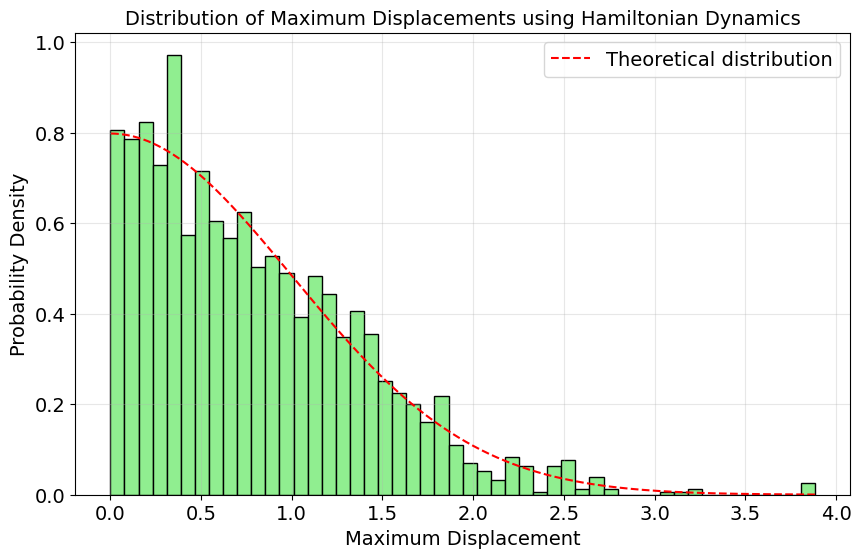

Average maximum displacement: 0.7993


In [6]:
print(">>> Using Hamiltonian Dynamics: ")

# Define the parameters
delta_t = 0.001  # Time step

# Initial conditions
x0 = 0.0

hamilton_system = HamiltonSystem(Hamilton_p_dot, Hamilton_x_dot, t_max, delta_t)

displacement_ls = []
for p0 in tqdm(p0_samples, desc="Loop in samples"):
    t_array, x_array, p_array = hamilton_system.simulate(x0, p0)
    displacement_ls.append((np.max(x_array) - np.min(x_array)) / 2)

# Create histogram of displacements
# * theoretical distribution is 1/2 * sqrt(k / (2 pi)) * x / sqrt(x^2 - x0^2) * exp(- k / 2 * (x^2 - x0^2))
plt.figure(figsize=(10, 6))
plt.hist(displacement_ls, bins=50, color='lightgreen', edgecolor='black', density=True)

# Calculate theoretical distribution
x_range = np.linspace(0, max(displacement_ls), 1000)
theoretical_dist = 0.5 * np.sqrt(k / (2 * np.pi)) * x_range / np.sqrt(x_range**2 - x0**2) * np.exp(-k/2 * (x_range**2 - x0**2))

# Normalize theoretical distribution
theoretical_dist_normalized = theoretical_dist * 4

# Plot theoretical distribution
plt.plot(x_range, theoretical_dist_normalized, 
         color='red', linestyle='--', label='Theoretical distribution')
plt.legend()

plt.title("Distribution of Maximum Displacements using Hamiltonian Dynamics")
plt.xlabel("Maximum Displacement")
plt.ylabel("Probability Density")
plt.grid(True, alpha=0.3)
plt.show()


# Calculate and print the average maximum displacement
avg_max_displacement = np.mean(displacement_ls)
print(f"Average maximum displacement: {avg_max_displacement:.4f}")


>>> Using Nambu Dynamics: 


Loop in samples: 100%|██████████| 2000/2000 [12:56<00:00,  2.57it/s]
/tmp/ipykernel_543864/789415792.py:22: RuntimeWarning: invalid value encountered in divide
  theoretical_dist = 0.5 * np.sqrt(k / (2 * np.pi)) * x_range / np.sqrt(x_range**2 - x0**2) * np.exp(-k/2 * (x_range**2 - x0**2))


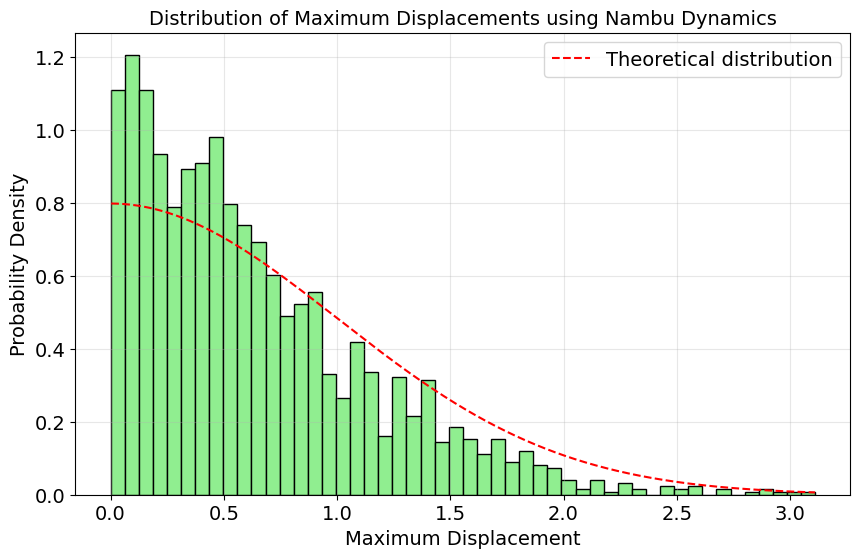

Average maximum displacement: 0.6358


In [7]:
print(">>> Using Nambu Dynamics: ")

# Define the parameters
delta_t = 0.0001  # Time step

# Initial conditions
x0 = 0.0

nambu_system = NambuSystem(Nambu_x_dot, Nambu_p_dot, Nambu_r_dot, t_max, delta_t)

displacement_ls = []
for p0, r0 in tqdm(zip(p0_samples, r0_samples), desc="Loop in samples", total=len(p0_samples)):
    t_array, x_array, p_array, r_array = nambu_system.simulate(x0, p0, r0)
    displacement_ls.append((np.max(x_array) - np.min(x_array)) / 2)

# Create histogram of displacements
plt.figure(figsize=(10, 6))
plt.hist(displacement_ls, bins=50, color='lightgreen', edgecolor='black', density=True)

# Calculate theoretical distribution
x_range = np.linspace(0, max(displacement_ls), 1000)
theoretical_dist = 0.5 * np.sqrt(k / (2 * np.pi)) * x_range / np.sqrt(x_range**2 - x0**2) * np.exp(-k/2 * (x_range**2 - x0**2))

# Normalize theoretical distribution
theoretical_dist_normalized = theoretical_dist * 4

# Plot theoretical distribution
plt.plot(x_range, theoretical_dist_normalized, 
         color='red', linestyle='--', label='Theoretical distribution')
plt.legend()

plt.title("Distribution of Maximum Displacements using Nambu Dynamics")
plt.xlabel("Maximum Displacement")
plt.ylabel("Probability Density")
plt.grid(True, alpha=0.3)
plt.show()

# Calculate and print the average maximum displacement
avg_max_displacement = np.mean(displacement_ls)
print(f"Average maximum displacement: {avg_max_displacement:.4f}")


### Test